# SI 671 Final Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import re
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Data Loading and Preprocessing

In [2]:
article_dt = pd.read_csv('nyt-articles-2020.csv')
comment_dt = pd.read_csv('nyt-comments-2020.csv.zip', compression = 'zip')

/var/folders/xq/h26tvj1x3fbfj2kh6r17zc_w0000gn/T/ipykernel_52654/4031504257.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  comment_dt = pd.read_csv('nyt-comments-2020.csv.zip', compression = 'zip')


In [3]:
article_dt['pub_date'] = pd.to_datetime(article_dt['pub_date'])
article_dt['keywords'] = article_dt['keywords'].astype(str)
article_dt['keyword_text'] = article_dt['keywords'].apply(lambda x: ' '.join([word for word in re.split(r'[^\w]', x) if word]))
article_dt['text'] = article_dt['abstract'] + article_dt['headline'] + article_dt['keyword_text']
article_dt['text'] = article_dt['text'].fillna('')

In [4]:
article_dt = article_dt[['uniqueID','pub_date','section','newsdesk','headline','abstract','keywords','text','word_count','n_comments']]
article_dt = article_dt.rename(columns = {'uniqueID' : 'articleID'})

In [5]:
comment_dt['createDate'] = pd.to_datetime(comment_dt['createDate'])
comment_dt = comment_dt[(comment_dt['createDate'] >= '2020-01-01 00:00:00') & (comment_dt['createDate'] < '2021-01-01 00:00:00')]
comment_dt = comment_dt[['userID','articleID','commentID','commentBody','createDate','updateDate']]

In [6]:
article_dt.shape, comment_dt.shape

((16787, 10), (4981987, 6))

## Analysis of Article Data

In [118]:
article_dt.sample(5)

,articleID,pub_date,section,newsdesk,headline,abstract,keywords,text,word_count,n_comments
15953,nyt://article/5be4c68d-d92d-5ac5-a5a3-0993dd20...,2020-12-10 22:37:11+00:00,Arts,Express,End of ‘One Day at a Time’ Removes One of TV’s...,"After being canceled last year by Netflix, the...","['Television', 'Hispanic-Americans', 'Cuban-Am...","After being canceled last year by Netflix, the...",639,6
15712,nyt://article/117652f3-2b0d-56c9-a080-1c1a50aa...,2020-12-06 19:23:31+00:00,Theater,Culture,How ‘Wolves’ and ‘Heroes’ Are Saving Pandemic ...,Serious new plays are always in danger of disa...,"['Theater', 'Coronavirus (2019-nCoV)', 'Heroes...",Serious new plays are always in danger of disa...,1247,12
4186,nyt://article/e7192885-a49c-549d-84e7-e45a15e9...,2020-03-27 14:36:52+00:00,Arts,Culture,"Bob Dylan’s 17-Minute Surprise, and 8 More New...",Hear tracks by PartyNextDoor featuring Rihanna...,"['Pop and Rock Music', 'Rap and Hip-Hop', 'Jaz...",Hear tracks by PartyNextDoor featuring Rihanna...,912,52
15156,nyt://article/27ec9712-b801-5b66-a6b2-0894f45a...,2020-11-21 10:00:09+00:00,The Upshot,Upshot,"No, a Negative Coronavirus Test Does Not Mean ...","A negative test is helpful, scientists and doc...","['Coronavirus (2019-nCoV)', 'Content Type: Ser...","A negative test is helpful, scientists and doc...",1212,297
10491,nyt://article/d63bb241-40a5-5bcc-8a5f-4a357048...,2020-08-07 09:00:18+00:00,Travel,Travel,Canada to U.S. Visitors: Please Don’t Sneak Ac...,"Some Canadian citizens, concerned about the sp...","['Coronavirus (2019-nCoV)', 'Travel and Vacati...","Some Canadian citizens, concerned about the sp...",1584,368


### Number of articles published every day and every month

In [119]:
daily_article_num = article_dt.groupby(article_dt['pub_date'].dt.date).size().reset_index().set_index('pub_date').rename(columns = {0: 'Count'})

In [120]:
monthly_article_num = article_dt.groupby(article_dt['pub_date'].dt.to_period('M').rename('pub_month')).size().reset_index().set_index('pub_month').rename(columns = {0:'Count'})

/var/folders/xq/h26tvj1x3fbfj2kh6r17zc_w0000gn/T/ipykernel_47562/1418001160.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_article_num = article_dt.groupby(article_dt['pub_date'].dt.to_period('M').rename('pub_month')).size().reset_index().set_index('pub_month').rename(columns = {0:'Count'})


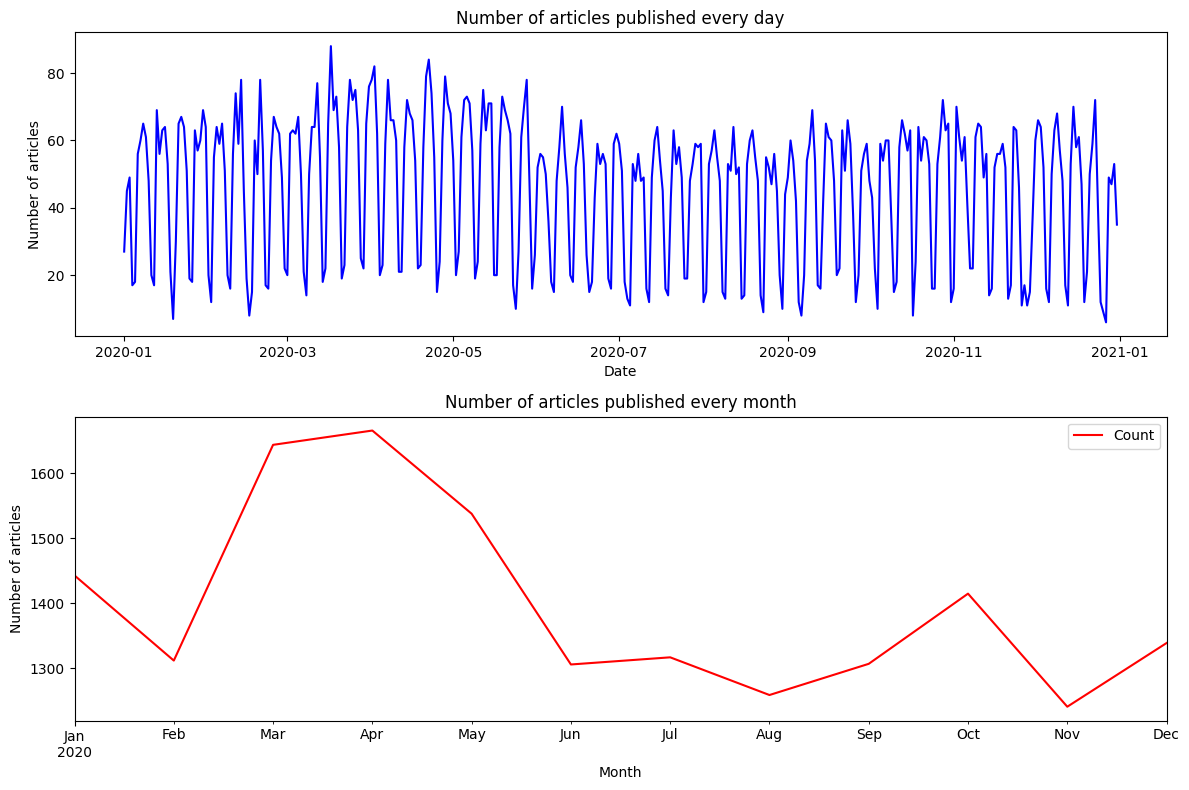

In [121]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12,8))
ax1.plot(daily_article_num, color = 'b')
ax1.set_title('Number of articles published every day')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of articles')

monthly_article_num.plot(ax = ax2, color = 'r')
ax2.set_title('Number of articles published every month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of articles')

plt.tight_layout()
plt.show()

Since the number of articles published every day shows a cyclic oscillitating trend, I want to find if there are some relationships between the article count and the weekday.

In [122]:
daily_article_num.index = pd.to_datetime(daily_article_num.index)
daily_article_num['weekday'] = daily_article_num.index.day_name()
weekday_article_num = daily_article_num.groupby('weekday').mean()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_article_num = weekday_article_num.reindex(weekday_order)
weekday_article_num

,Count
weekday,
Monday,52.788462
Tuesday,62.538462
Wednesday,62.113208
Thursday,60.150943
Friday,49.211538
Saturday,17.038462
Sunday,16.634615


We can see that more articles are published on Tuesday, Wednesday and Thursday, while much less articles are published at weekends.

### Number of articles published during different time period in a day

In [177]:
article_hour_dt = article_dt[article_dt.columns]
article_hour_dt['hour_of_day'] = article_hour_dt['pub_date'].dt.hour

night = (article_hour_dt['hour_of_day'] >= 0) & (article_hour_dt['hour_of_day'] <= 5)
morning = (article_hour_dt['hour_of_day'] >= 6) & (article_hour_dt['hour_of_day'] <= 11)
afternoon = (article_hour_dt['hour_of_day'] >= 12) & (article_hour_dt['hour_of_day'] <= 17)
evening = (article_hour_dt['hour_of_day'] >= 18) & (article_hour_dt['hour_of_day'] <= 23)

article_hour_dt.loc[night, 'day_segment'] = 'Night'
article_hour_dt.loc[morning, 'day_segment'] = 'Morning'
article_hour_dt.loc[afternoon, 'day_segment'] = 'Afternoon'
article_hour_dt.loc[evening, 'day_segment'] = 'Evening'

/var/folders/xq/h26tvj1x3fbfj2kh6r17zc_w0000gn/T/ipykernel_47562/1749564616.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Night' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  article_hour_dt.loc[night, 'day_segment'] = 'Night'


In [178]:
article_hour_dt['day_segment'].value_counts()

day_segment
Morning      7494
Afternoon    3972
Evening      3509
Night        1812
Name: count, dtype: int64

### Article number distribution in each section

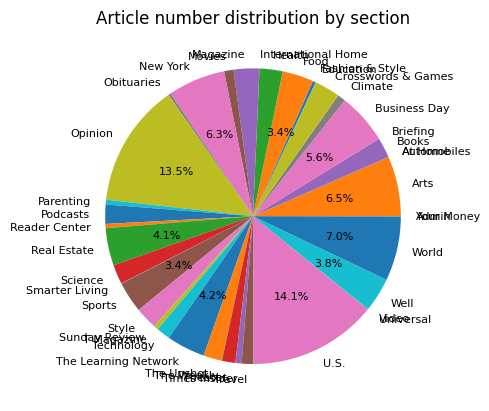

In [123]:
article_num_section = article_dt.groupby('section').size().reset_index().rename(columns = {0: 'article_num'})

def my_autopct(pct):
    return f'{pct:.1f}%' if pct > 3 else ''

plt.pie(article_num_section['article_num'], labels = article_num_section['section'], autopct = my_autopct, textprops={'fontsize': 8})
plt.title('Article number distribution by section')
plt.show()

### Articles with most comments

In [124]:
sorted_article_dt = article_dt.sort_values(by = 'n_comments', ascending = False)
hot_headlines = sorted_article_dt.iloc[:10, :]['headline'].tolist()
#hot_headline_section = sorted_article_dt.iloc[:10, :]['section'].tolist()
print('Most commented articles (top 10):')
for i in range(10):
    #print(f'{i+1}. {hot_headlines[i]} ----- Section {hot_headline_section[i]}')
    print(f'{i+1}. {hot_headlines[i]}')

Most commented articles (top 10):
1. Trump’s Taxes Show Chronic Losses and Years of Income Tax Avoidance
2. Bernie Sanders Is Making a Big Mistake
3. Democrats, It’s Time to Consider a Plan B
4. Why Prosecuting Trump Is a Very Bad Idea
5. Vote for Trump’s Worst!
6. White Woman Is Fired After Calling Police on Black Man in Central Park
7. No, Not Sanders, Not Ever
8. U.S. Strike in Iraq Kills Qassim Suleimani, Commander of Iranian Forces
9. He Could Have Seen What Was Coming: Behind Trump’s Failure on the Virus
10. Tear Gas Clears Path for Trump to Visit Church


#### Articles with most comments in every month

In [7]:
monthly_article_dt = {}
for month in range(1,13):
    monthly_article_dt[month] = article_dt[article_dt['pub_date'].dt.month == month].copy()

In [12]:
for i in range(1,13):
    sorted_article = monthly_article_dt[i].sort_values(by = 'n_comments', ascending = False)
    hot_headline = sorted_article.iloc[:5,:]['headline'].tolist()
    print(f'Month: {i}')
    for j in range(5):
        print(f'{j+1}. {hot_headline[j]}')

Month: 1
1. U.S. Strike in Iraq Kills Qassim Suleimani, Commander of Iranian Forces
2. Who Killed the Knapp Family?
3. ‘Nobody Likes Him’: Hillary Clinton Risks a Party Split Over Bernie Sanders
4. Republicans Move to Block Impeachment Witnesses, Driving Toward Acquittal
5. The Bernie Sanders Fallacy
Month: 2
1. Bernie Sanders Is Making a Big Mistake
2. No, Not Sanders, Not Ever
3. Democratic Leaders Willing to Risk Party Damage to Stop Bernie Sanders
4. Barr Says Attacks From Trump Make Work ‘Impossible’
5. Paging Michael Bloomberg
Month: 3
1. He Has 17,700 Bottles of Hand Sanitizer and Nowhere to Sell Them
2. Elizabeth Warren, Once a Front-Runner, Drops Out of Presidential Race
3. As State Pleas Mount, Trump Outlines Some Federal Action; Senate Democrats Block Stimulus Package
4. Thank God the Doctor Is In
5. Behind Bernie Sanders’s Decision to Stay in the Race
Month: 4
1. He Could Have Seen What Was Coming: Behind Trump’s Failure on the Virus
2. Bernie Sanders Drops Out of 2020 Demo

In order to see the most frequent words in these heated articles, I first lemmatizer the words in the headlines and abstracts.

In [125]:
def process_words(text):
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    words_new = [lemmatizer.lemmatize(word) for word in words]
    return words_new

In [126]:
article_top_dt = sorted_article_dt.iloc[:10,:]
article_top_dt['words'] = article_top_dt['text'].apply(process_words)

/var/folders/xq/h26tvj1x3fbfj2kh6r17zc_w0000gn/T/ipykernel_47562/2830810888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_top_dt['words'] = article_top_dt['text'].apply(process_words)


In [127]:
top_words = []
for words in article_top_dt['words'].tolist():
    top_words.extend(words)

In [128]:
top_word_count = dict(sorted(Counter(top_words).items(), key=lambda item: item[1], reverse=True))

In [129]:
top_word_count

{'and': 31,
 'of': 15,
 'Trump': 13,
 'States': 11,
 'the': 11,
 'Politics': 9,
 'to': 9,
 'a': 9,
 'Donald': 8,
 'in': 8,
 '2020': 8,
 'United': 8,
 'J': 7,
 'US': 7,
 'Presidential': 6,
 'Election': 6,
 'Government': 6,
 'for': 6,
 'Tax': 5,
 'Democratic': 5,
 'National': 4,
 'L': 4,
 'Iraq': 4,
 'The': 3,
 'Trump’s': 3,
 'Is': 3,
 'Health': 3,
 'Party': 3,
 'R': 3,
 'his': 3,
 'Robert': 3,
 'Mike': 3,
 'on': 3,
 'Central': 3,
 'Forces': 3,
 'International': 3,
 'an': 2,
 'Income': 2,
 'Returns': 2,
 'Organization': 2,
 'Real': 2,
 'Estate': 2,
 'Travel': 2,
 'Sanders': 2,
 'Presidents': 2,
 'Presidency': 2,
 'Immigration': 2,
 'Bernard': 2,
 'Liberalism': 2,
 'Tara': 2,
 'Jr': 2,
 'would': 2,
 'be': 2,
 'faith': 2,
 'but': 2,
 'Department': 2,
 'is': 2,
 'Azar': 2,
 'Alex': 2,
 'M': 2,
 'II': 2,
 'Pence': 2,
 'Video': 2,
 'about': 2,
 'Police': 2,
 'Park': 2,
 'Cooper': 2,
 'Not': 2,
 'Suleimani': 2,
 'wa': 2,
 'planning': 2,
 'Qassim': 2,
 'Defense': 2,
 'Military': 2,
 'Relations'

### Most frequent words in articles published in 2020

In [130]:
article_word = article_dt['text'].apply(process_words).tolist()

In [131]:
article_words = []
for words in article_word:
    article_words.extend(words)

In [132]:
article_words_cnt = dict(sorted(Counter(article_words).items(), key=lambda item: item[1], reverse=True))

In [133]:
i = 0
for k,v in article_words_cnt.items():
    print(f'{k}: {v}')
    i += 1
    if i > 20:
        break

and: 37145
the: 23197
of: 16628
a: 14790
to: 13273
in: 9575
States: 5709
for: 5604
2019: 5491
nCoV: 5378
Coronavirus: 5271
United: 5024
The: 4959
Trump: 4108
on: 3810
Government: 3651
New: 3598
Politics: 3595
2020: 3470
J: 3143
is: 3123


### Word vectorization using TF-IDF

In [134]:
def process_words2(text):
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    words_new = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words_new)

In [135]:
texts = article_dt['text'].apply(process_words2).tolist()

In [136]:
vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.5)
vectorized_text = vectorizer.fit_transform(texts)
print("Shape of Matrix:", vectorized_text.shape)
terms = vectorizer.get_feature_names_out()
print("Number of terms:", len(terms))

Shape of Matrix: (16787, 45246)
Number of terms: 45246


### Use SVD to extract dominant topics

In [137]:
keyword_list = []
svd_model = TruncatedSVD(n_components=5, random_state=671)
svd_model.fit(vectorized_text)
    
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:20]
    keyword_list.append(sorted_terms)

In [138]:
for topic in keyword_list:
    print([t[0] for t in topic])
    print('-'*60)

['trump', 'states', 'united', 'election', 'coronavirus', 'politics', 'government', '2020', 'donald', 'party', 'biden', 'presidential', '2019', 'ncov', 'jr', 'joseph', 'democratic', 'new', 'president', 'republican']
------------------------------------------------------------
['coronavirus', 'new', 'york', 'ncov', '2019', 'city', 'ny', 'life', 'quarantines', 'pandemic', 'health', 'estate', 'medical', 'reopenings', 'housing', 'manhattan', 'quarantine', 'culture', 'virus', 'residential']
------------------------------------------------------------
['york', 'new', 'city', 'police', 'black', 'protests', 'ny', 'floyd', '2020', 'tv', 'biden', 'george', 'program', 'election', 'movement', 'matter', 'blacks', 'lives', 'manhattan', 'brutality']
------------------------------------------------------------
['tv', 'program', 'jimmy', 'late', 'noah', 'trevor', 'stephen', 'colbert', 'meyers', 'seth', 'kimmel', 'night', 'trump', 'fallon', '1984', 'daily', 'tonight', 'live', 'donald', 'corden']
--------

### Use LDA to extract dominant topics

In [139]:
lda = LatentDirichletAllocation(n_components = 5, random_state = 671, verbose = 1)
lda_matrix = lda.fit_transform(vectorized_text)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [140]:
def lda_top_topics(model, feature, n):
    for idx, topic in enumerate(model.components_):
        s = 'Topic ' + str(idx+1) + ': '
        s += ', '.join([feature[i] for i in topic.argsort()[:-n-1:-1]])
        print(s)

In [141]:
n = 10
lda_top_topics(lda, terms, n)

Topic 1: trump, states, united, coronavirus, government, election, politics, 2020, donald, 2019
Topic 2: estate, housing, ny, residential, new, real, manhattan, york, city, calif
Topic 3: new, york, city, coronavirus, police, ncov, 2019, black, hospitals, medical
Topic 4: china, military, states, defense, united, international, puzzles, stock, crossword, forces
Topic 5: tv, program, feed, coronavirus, science, 2019, ncov, children, life, health


### Wordcloud of articles in 2020

In [142]:
from wordcloud import WordCloud

In [150]:
tfidf_weights = {word: vectorized_text.getcol(idx).sum() for word, idx in vectorizer.vocabulary_.items()}

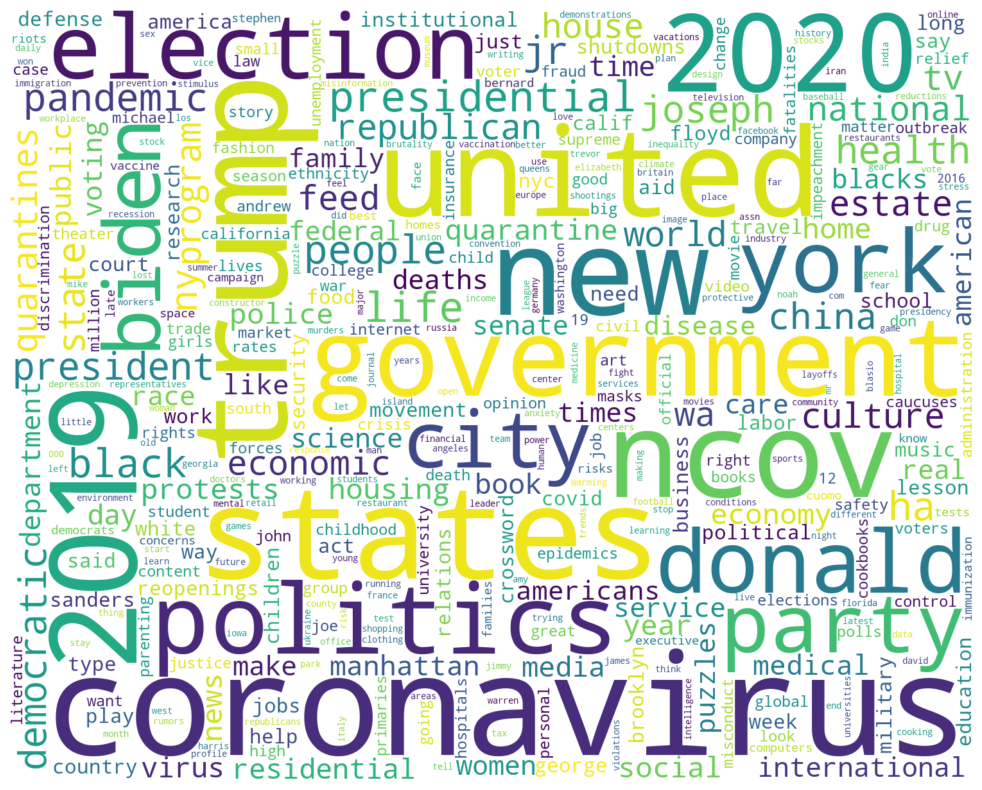

<Figure size 640x480 with 0 Axes>

In [154]:
wordcloud = WordCloud(width = 1500, height = 1200, mode = 'RGBA', background_color='white', max_words = 400).generate_from_frequencies(tfidf_weights)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Analysis of Comment Data

In [156]:
comment_dt.sample(5)

,userID,articleID,commentID,commentBody,createDate,updateDate
2932380,138385471,nyt://article/b83ed1a4-68f4-5438-9280-6d364a36...,108253575,As a student I feel as though it is important ...,2020-07-21 17:39:40,2020-08-07 15:10:41
1512595,65349518,nyt://article/7ca1f585-4583-5252-b00d-16eba7f3...,106326773,Animal husbandry accounts for only about 2.5% ...,2020-04-07 22:57:04,2020-04-08 09:31:17
4045467,98283900,nyt://article/061a9653-4228-57c1-9453-e57abbd1...,109596841,What Mitch is doing is criminal. He is indeed ...,2020-10-13 00:21:59,2020-10-13 13:08:08
1237547,69131720,nyt://article/33ab88ff-6ffe-5b61-9c0f-420b9047...,105974765,@Sam I Am \n\nInflation is not caused by “mone...,2020-03-22 18:53:05,2020-07-03 20:32:34
1365409,68500603,nyt://article/427564c0-5fd5-50c1-8810-04937d2e...,106129823,@Llama he is a professional grifter. What oth...,2020-03-29 22:26:46,2020-03-30 02:05:52


### Number of comments per user

In [159]:
user_comment_num = comment_dt.groupby('userID').size().reset_index().rename(columns = {0: 'Count'})

In [162]:
avg_comment_num = user_comment_num['Count'].mean()
max_comment_num = user_comment_num['Count'].max()
print(f'Average number of comments posted by each user: {avg_comment_num}, Max number of comments posted by a user: {max_comment_num}')

Average number of comments posted by each user: 12.372812028133195, Max number of comments posted by a user: 8802


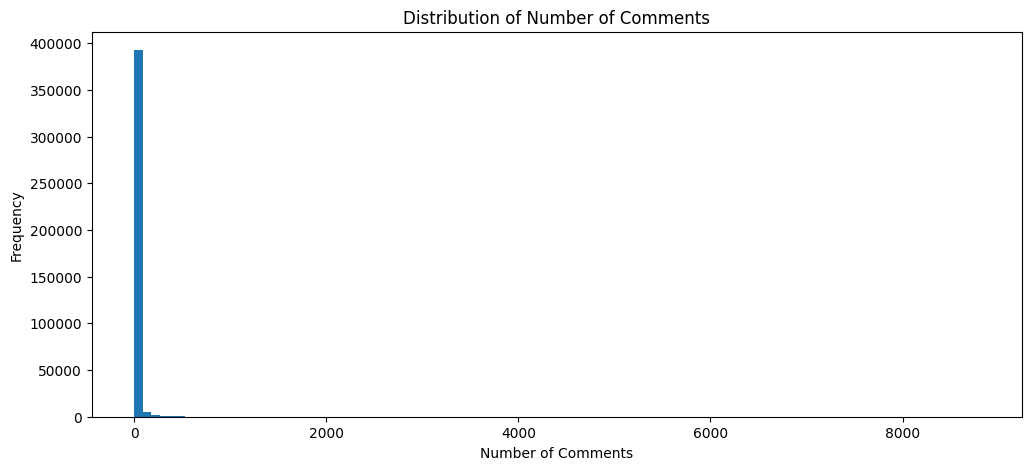

In [167]:
# Plot the distribution of number of comments
plt.figure(figsize = (12,5))
plt.hist(user_comment_num['Count'], bins=100)
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Comments')
plt.show()

### User active time period

In [168]:
comment_hour_dt = comment_dt[comment_dt.columns]
comment_hour_dt['hour_of_day'] = comment_hour_dt['createDate'].dt.hour
comment_hour_dt['week_day'] = comment_hour_dt['createDate'].dt.day_name()

#### User active weekdays

In [170]:
comment_hour_dt['week_day'].value_counts()

week_day
Wednesday    859286
Tuesday      846414
Thursday     829092
Friday       825751
Monday       732404
Saturday     450577
Sunday       438463
Name: count, dtype: int64

#### User active segment of day

In this part, one day is partitioned into four segments: 'Morning' for 6AM to 12PM, 'Afternoon' for 12PM to 6PM, 'Evening' from 6PM to 12AM, and 'Night' for 12AM to 6AM.

In [172]:
night = (comment_hour_dt['hour_of_day'] >= 0) & (comment_hour_dt['hour_of_day'] <= 5)
morning = (comment_hour_dt['hour_of_day'] >= 6) & (comment_hour_dt['hour_of_day'] <= 11)
afternoon = (comment_hour_dt['hour_of_day'] >= 12) & (comment_hour_dt['hour_of_day'] <= 17)
evening = (comment_hour_dt['hour_of_day'] >= 18) & (comment_hour_dt['hour_of_day'] <= 23)

comment_hour_dt.loc[night, 'day_segment'] = 'Night'
comment_hour_dt.loc[morning, 'day_segment'] = 'Morning'
comment_hour_dt.loc[afternoon, 'day_segment'] = 'Afternoon'
comment_hour_dt.loc[evening, 'day_segment'] = 'Evening'

/var/folders/xq/h26tvj1x3fbfj2kh6r17zc_w0000gn/T/ipykernel_20964/2478379637.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Night' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  comment_hour_dt.loc[night, 'day_segment'] = 'Night'


In [173]:
comment_hour_dt['day_segment'].value_counts()

day_segment
Afternoon    2094779
Evening      1540903
Night         903772
Morning       442533
Name: count, dtype: int64

It may also be meaningful to see the trend of user active time period in 2020.

In [174]:
comment_daysegment_num = comment_hour_dt.groupby([comment_hour_dt['createDate'].dt.date, 'day_segment']).size().reset_index().set_index('createDate').rename(columns = {0:'Count'})

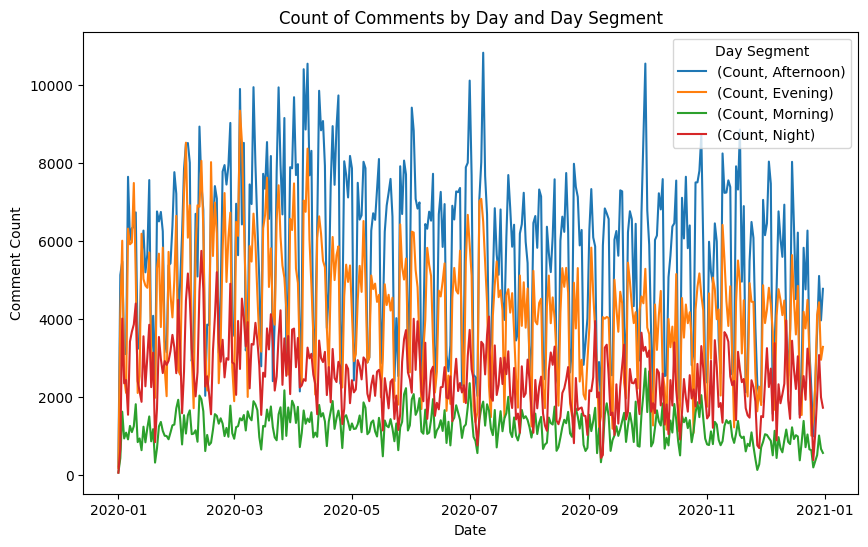

In [175]:
pivot_table = comment_daysegment_num.pivot_table(columns='day_segment', index='createDate')
pivot_table.plot(kind='line', figsize=(10, 6))
plt.title('Count of Comments by Day and Day Segment')
plt.xlabel('Date')
plt.ylabel('Comment Count')
plt.legend(title = 'Day Segment')
plt.show()

### User interested section

In [215]:
comment_num_section = article_dt.groupby('section')['n_comments'].sum().reset_index().rename(columns = {0: 'comment_num'})

In [222]:
article_comment_section = article_num_section.merge(comment_num_section, how = 'inner', on = 'section')

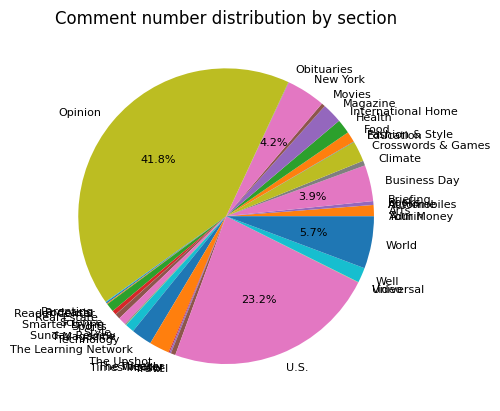

In [240]:
def my_autopct(pct):
    return f'{pct:.1f}%' if pct > 3 else ''

plt.pie(comment_num_section['n_comments'], labels = comment_num_section['section'], autopct = my_autopct, textprops={'fontsize': 8})
plt.title('Comment number distribution by section')

plt.show()

Since the number of comments may increase as the number of articles published in certain section increase, I use their quotient to measure users' interest in certain news section.

In [226]:
article_comment_section['n_comments per article'] = article_comment_section['n_comments'] / article_comment_section['article_num']
article_comment_section.sort_values(by = 'n_comments per article', ascending = False)

,section,article_num,n_comments,n_comments per article
18,Opinion,2272,2082114,916.423415
27,Sunday Review,7,5469,781.285714
38,Video,3,1812,604.000000
36,U.S.,2364,1156457,489.195008
31,The Upshot,338,109273,323.292899
13,International Home,1,263,263.000000
40,World,1183,284874,240.806424
8,Crosswords & Games,468,111934,239.175214
14,Magazine,471,109963,233.467091
6,Business Day,932,196889,211.254292


This illustrates that users are more enthusiastic on articles in sections such as 'Opinion', 'U.S.', 'The Upshot', and 'World', but less interested in sections such as 'Podcasts', 'Theater', 'Sports', 'Arts', and 'Books'.

### Time interval between user comment and article publication 

In [162]:
article_comment_dt = article_dt.merge(comment_dt, how = 'inner', on = 'articleID')

In [163]:
article_comment_dt['createDate'] = article_comment_dt['createDate'].dt.tz_localize('UTC')
article_comment_dt['pub_date'] = article_comment_dt['pub_date'].dt.tz_convert('UTC')

In [164]:
article_comment_interval = article_comment_dt['createDate'] - article_comment_dt['pub_date']

In [168]:
print(f'Average time interval: {article_comment_interval.mean()}')
print(f'Max time interval: {article_comment_interval.max()}')

Average time interval: 0 days 23:32:27.568951304
Max time interval: 355 days 18:48:21


In [175]:
article_comment_interval_seconds = article_comment_interval.dt.total_seconds()
intervals_less_than_one_day = article_comment_interval_seconds[article_comment_interval_seconds < 86400]
count_intervals_less_than_one_day = len(intervals_less_than_one_day)
print(f'Proportion of time interval less than one day: {count_intervals_less_than_one_day / len(article_comment_interval)}')

Proportion of time interval less than one day: 0.8831873708221237


We see that most comments are posted within 24 hours of the article being published.

In [179]:
intervals_less_than_12h = article_comment_interval_seconds[article_comment_interval_seconds < 12*60*60]
count_intervals_less_than_12h = len(intervals_less_than_12h)
print(f'Proportion of time interval less than 12 hours: {count_intervals_less_than_12h / len(article_comment_interval)}')

Proportion of time interval less than 12 hours: 0.5619825985093899


In [180]:
intervals_less_than_6h = article_comment_interval_seconds[article_comment_interval_seconds < 6*60*60]
count_intervals_less_than_6h = len(intervals_less_than_6h)
print(f'Proportion of time interval less than 6 hours: {count_intervals_less_than_6h / len(article_comment_interval)}')

Proportion of time interval less than 6 hours: 0.28456196292764313


In [181]:
intervals_less_than_18h = article_comment_interval_seconds[article_comment_interval_seconds < 18*60*60]
count_intervals_less_than_18h = len(intervals_less_than_18h)
print(f'Proportion of time interval less than 18 hours: {count_intervals_less_than_18h / len(article_comment_interval)}')

Proportion of time interval less than 18 hours: 0.7797746160317158


### Difference of article preference between different users

In [182]:
article_comment_dt.head()

,articleID,pub_date,section,newsdesk,headline,abstract,keywords,text,word_count,n_comments,userID,commentID,commentBody,createDate,updateDate
0,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,2020-01-01 00:18:54+00:00,Opinion,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",Congress could do much more to protect America...,680,186,60215558,104387472,Here is something I think is fraudulent that v...,2020-01-01 01:05:46+00:00,2020-01-01 08:13:39
1,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,2020-01-01 00:18:54+00:00,Opinion,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",Congress could do much more to protect America...,680,186,65691034,104387873,@magicisnotreal I have used my VA loan option...,2020-01-01 01:52:25+00:00,2020-01-01 20:55:19
2,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,2020-01-01 00:18:54+00:00,Opinion,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",Congress could do much more to protect America...,680,186,65110053,104387976,@magi\n\nWhy would someone take out a VA loan ...,2020-01-01 02:06:05+00:00,2020-01-01 20:55:35
3,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,2020-01-01 00:18:54+00:00,Opinion,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",Congress could do much more to protect America...,680,186,60215558,104390628,@JD\nOut here in the Alabama of the PNW they w...,2020-01-01 14:38:50+00:00,2020-01-01 20:56:46
4,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,2020-01-01 00:18:54+00:00,Opinion,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",Congress could do much more to protect America...,680,186,65691034,104391463,@magicisnotreal just a guess but I doubt that...,2020-01-01 16:23:14+00:00,2020-01-01 16:25:57


In [186]:
article_comment_dt[article_comment_dt['createDate'] >= '2020-03-01 00:00:00']

,articleID,pub_date,section,newsdesk,headline,abstract,keywords,text,word_count,n_comments,userID,commentID,commentBody,createDate,updateDate
439,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...,2020-01-01 03:00:10+00:00,Crosswords & Games,Games,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],Christina Iverson and Jeff Chen ring in the Ne...,931,257,131726517,107340837,@Lauren Harsh. Your problem with Scottish men ...,2020-05-31 18:29:34+00:00,2020-05-31 18:29:34
442,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...,2020-01-01 03:00:10+00:00,Crosswords & Games,Games,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],Christina Iverson and Jeff Chen ring in the Ne...,931,257,85960937,108150730,Did you know Jamal Khashoggi personally? I was...,2020-07-15 21:22:47+00:00,2020-07-15 21:22:48
4635,nyt://article/2c1db271-b8ce-565e-a259-8e0b7a52...,2020-01-02 03:00:02+00:00,Crosswords & Games,Games,Where Darth Vader Gets His Strength,Ed Sessa turns the lights out on us.,['Crossword Puzzles'],Ed Sessa turns the lights out on us.Where Dart...,1151,194,131726517,107455486,@artlife It doesn't let me use the undo button...,2020-06-05 17:02:59+00:00,2020-06-05 17:03:00
4654,nyt://article/2c1db271-b8ce-565e-a259-8e0b7a52...,2020-01-02 03:00:02+00:00,Crosswords & Games,Games,Where Darth Vader Gets His Strength,Ed Sessa turns the lights out on us.,['Crossword Puzzles'],Ed Sessa turns the lights out on us.Where Dart...,1151,194,131726517,107455415,TIL that a Dark'N'Stormy is my favorite cockta...,2020-06-05 16:59:32+00:00,2020-06-05 16:59:33
5045,nyt://article/070c28db-dccc-5ba1-9d03-5e999904...,2020-01-02 10:00:03+00:00,The Learning Network,Learning,What Are Your Predictions for the New Year and...,What do you think will change in our world in ...,[],What do you think will change in our world in ...,788,109,145271816,109407466,It doesn’t look too bright for us generation z...,2020-10-01 03:51:51+00:00,2020-10-01 04:36:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4981982,nyt://article/12048b2b-62e3-5bed-8c77-483a4299...,2020-12-31 18:02:02+00:00,Technology,Business,Microsoft Says Russian Hackers Viewed Some of ...,The hackers gained more access than the compan...,"['Microsoft Corp', 'US Federal Government Data...",The hackers gained more access than the compan...,340,137,76126272,110840212,"We act like this is some kind of surprise, whe...",2020-12-31 22:59:30+00:00,2021-01-03 12:18:43
4981983,nyt://article/12048b2b-62e3-5bed-8c77-483a4299...,2020-12-31 18:02:02+00:00,Technology,Business,Microsoft Says Russian Hackers Viewed Some of ...,The hackers gained more access than the compan...,"['Microsoft Corp', 'US Federal Government Data...",The hackers gained more access than the compan...,340,137,91375622,110839970,They probably ran screaming and laughing when ...,2020-12-31 22:43:24+00:00,2021-01-01 16:13:19
4981984,nyt://article/12048b2b-62e3-5bed-8c77-483a4299...,2020-12-31 18:02:02+00:00,Technology,Business,Microsoft Says Russian Hackers Viewed Some of ...,The hackers gained more access than the compan...,"['Microsoft Corp', 'US Federal Government Data...",The hackers gained more access than the compan...,340,137,34452477,110840976,Again we thank Trump for putting Americans and...,2020-12-31 23:52:04+00:00,2021-01-04 10:54:06
4981985,nyt://article/12048b2b-62e3-5bed-8c77-483a4299...,2020-12-31 18:02:02+00:00,Technology,Business,Microsoft Says Russian Hackers Viewed Some of ...,The hackers gained more access than the compan...,"['Microsoft Corp', 'US Federal Government Data...",The hackers gained more access than the compan...,340,137,72115318,110840994,I am still wondering if solarwinds has an offi...,2020-12-31 23:53:26+00:00,2021-01-01 15:58:10


In [189]:
lst1 = article_comment_dt[article_comment_dt['userID'] == 131726517]['newsdesk'].tolist()

In [190]:
cnt = 0
for i in lst1:
    if i != 'Games':
        print(i)
        cnt += 1

In [193]:
print(len(lst1))

1202


In [194]:
df2 = article_comment_dt[article_comment_dt['userID'] == 34452477]

In [197]:
df2.shape

(464, 15)

In [196]:
for k,v in Counter(df2['section'].tolist()).items():
    print(k,v)

World 51
Opinion 53
U.S. 222
Health 14
Movies 9
New York 21
Well 4
Sports 2
Food 6
Real Estate 2
T Magazine 1
Business Day 30
Magazine 4
Arts 8
Style 16
Books 3
Technology 4
Reader Center 1
The Upshot 5
Climate 4
Science 4


## Time-aware recommendation model

### Prepare train and test data

In [7]:
comment_train = comment_dt[(comment_dt['createDate'] >= '2020-01-01 00:00:00') & (comment_dt['createDate'] < '2020-04-01 00:00:00')]

In [8]:
comment_train.shape

(1392777, 6)

In [9]:
user_comment_cnt  = comment_dt.groupby('userID').size().reset_index().rename(columns = {0:'Count'})
valid_user = user_comment_cnt[user_comment_cnt['Count'] >= 10].userID.to_list()
len(valid_user)

61398

In [10]:
comment_train = comment_train[comment_train['userID'].isin(valid_user)]

In [11]:
comment_test = comment_dt[(comment_dt['createDate'] >= '2020-04-01 00:00:00') & (comment_dt['createDate'] < '2020-04-11 00:00:00')]

In [12]:
# join article data and comment data
article_comment_train = article_dt.merge(comment_train, on = 'articleID', how = 'inner')
article_comment_test = article_dt.merge(comment_test, on = 'articleID', how = 'inner')
article_train = article_dt[article_dt['articleID'].isin(article_comment_train['articleID'].unique())]
article_test = article_dt[article_dt['articleID'].isin(article_comment_test['articleID'].unique())]

## News Popularity Prediction

### Pretrain a word2vec model

In [19]:
def pretrain_word2vec_model(article_dt):
    sentences = [word_tokenize(sentence) for text in article_dt['text'].to_list() for sentence in re.split(r'[^\w]', text) if sentence]
    word2vec_model = Word2Vec(sentences, vector_size = 100, window = 5, min_count = 2)
    word2vec_model.save('word2vec_model.model')

In [123]:
pretrain_word2vec_model(article_dt)

### Build news popularity prediction model

In [13]:
class news_popularity_pred(nn.Module):
    def __init__(self, content_embedding_dim = 100, hidden_size = (32,16), dropout_prob = 0.5, epochs = 30, batchsize = 16, lr = 0.0003):
        super(news_popularity_pred, self).__init__()
        self.content_embedding_dim = content_embedding_dim
        self.hidden_size = hidden_size
        self.dropout_prob = dropout_prob
        self.epochs = epochs
        self.batchsize = batchsize
        self.lr = lr
        self.net = nn.Sequential(
            nn.Linear(self.content_embedding_dim + 1, self.hidden_size[0]),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_prob),
            nn.Linear(self.hidden_size[0], self.hidden_size[1]),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_prob),
            nn.Linear(self.hidden_size[1], 1)
        )
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr = self.lr)
        
    '''def get_word_num(self):
        text = ' '.join(self.article_data['text'])
        tokens = word_tokenize(text)
        return len(tokens)'''
    
    def article_id_map(self, article_dt):
        ids = article_dt['articleID'].unique()
        id_to_idx = {id_text: idx for idx, id_text in enumerate(ids)}
        return id_to_idx
        
    '''def save_word2vec_model(self, article_dt):
        sentences = [word_tokenize(sentence) for text in article_dt['text'].to_list() for sentence in re.split(r'[^\w]', text) if sentence]
        word2vec_model = Word2Vec(sentences, vector_size = self.content_embedding_dim, window = 5, min_count = 3)
        word2vec_model.save('word2vec_model.model')'''
    
    def text_to_w2v_embedding(self, text, model):
        words = re.split(r'[^\w]', text)
        words = [word for word in words if word in model.wv]
        if not words:
            return np.zeros(self.content_embedding_dim)
        return np.mean([model.wv[word] for word in words], axis = 0)
    
    def content_embedding(self, article_dt):
        #self.save_word2vec_model(self.article_data)
        word2vec_model = Word2Vec.load('word2vec_model.model')
        content_emb = article_dt['text'].apply(lambda x: self.text_to_w2v_embedding(x, word2vec_model))
        content_embedding = np.vstack(content_emb)
        m = np.mean(content_embedding, axis = 0)
        s = np.std(content_embedding, axis = 0)
        content_embedding = (content_embedding - m) / s
        return content_embedding
    
    def recency_embedding(self, article_dt, cur_time):
        cur_time = pd.to_datetime(cur_time)
        recencies = (cur_time - pd.to_datetime(article_dt['pub_date']).dt.tz_localize(None)).dt.total_seconds() / 3600
        recencies = recencies.to_numpy()
        recencies = (recencies - min(recencies)) / (max(recencies) - min(recencies))
        #normalized_recency = (recencies - recencies.mean()) / recencies.std()
        return recencies
    
    def content_recency_embedding(self, article_dt, cur_time):
        content = self.content_embedding(article_dt)
        recency = self.recency_embedding(article_dt, cur_time)
        combined = np.concatenate((content, recency.reshape((-1,1))), axis = 1)
        
        return combined
    
    def total_comment(self, article_comment_dt, cur_time, articleid):
        comment_till_cur = article_comment_dt[article_comment_dt['createDate'] <= cur_time]
        comment_cnt = comment_till_cur.groupby('articleID').size().reset_index(name = 'comment_count')
        comment_cnt = comment_cnt.set_index('articleID').reindex(article_comment_dt['articleID'].unique(), fill_value=0)
        return comment_cnt.loc[articleid,:].item()
    
    def article_popularity(self, article_comment_dt, cur_time):
        articles = article_comment_dt['articleID'].unique()
        comment_till_cur = article_comment_dt[article_comment_dt['createDate'] <= cur_time]
        comment_cnt = comment_till_cur.groupby('articleID').size().reset_index(name = 'comment_count')
        comment_cnt = comment_cnt.set_index('articleID').reindex(article_comment_dt['articleID'].unique(), fill_value=0)
        popularities = pd.DataFrame({'articleID': articles})
        popularities = popularities.merge(comment_cnt, on = 'articleID', how = 'left').fillna(0)
        total = popularities['comment_count'].sum()
        popularities['popularity'] = popularities['comment_count'] / total
        popularities['popularity'] = (popularities['popularity'] - min(popularities['popularity'])) / (max(popularities['popularity']) - min(popularities['popularity']))
        return popularities['popularity'].to_numpy()
        
    def forward(self, x):
        #x = self.content_recency_embedding(article_dt, cur_time)
        #x = torch.FloatTensor(x)
        output = self.net(x)
        return output
    
    def model_training(self, train_x, train_y):
        train_dataset = TensorDataset(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
        train_loader = DataLoader(train_dataset, batch_size = self.batchsize, shuffle = True)

        avg_loss_lst = []
        for epoch in range(self.epochs):
            self.train()
            total_loss = 0

            for x, y in train_loader:
                self.optimizer.zero_grad()
                pred = self.forward(x)
                loss = self.criterion(pred, y)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {avg_loss}")
            avg_loss_lst.append(avg_loss)
        return avg_loss_lst

    def model_evaluation(self, val_x, val_y):
        val_dataset = TensorDataset(torch.FloatTensor(val_x), torch.FloatTensor(val_y))
        val_loader = DataLoader(val_dataset, batch_size = self.batchsize)
        
        self.eval()
        total_loss = 0

        with torch.no_grad():
            for x,y in val_loader:
                pred = self.forward(x)
                loss = self.criterion(pred, y)
                total_loss += loss.item()

        avg_loss = total_loss / len(val_loader)
        print(f"Evaluation Loss: {avg_loss}")

### Train the model

In [14]:
popularity_pred_model = news_popularity_pred()

In [15]:
cur_time_train = '2020-04-01 00:00:00'
cur_time_test = '2020-04-11 00:00:00'
train_x = popularity_pred_model.content_recency_embedding(article_train, cur_time_train)
train_y = popularity_pred_model.article_popularity(article_comment_train, cur_time_train)
test_x = popularity_pred_model.content_recency_embedding(article_test, cur_time_test)
test_y = popularity_pred_model.article_popularity(article_comment_test, cur_time_test)

In [16]:
avg_losses = popularity_pred_model.model_training(train_x, train_y)

/usr/local/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/30, Loss: 0.02332588934029142
Epoch 2/30, Loss: 0.013437323081652047
Epoch 3/30, Loss: 0.011559698152079903
Epoch 4/30, Loss: 0.01080815474399262
Epoch 5/30, Loss: 0.01046584429503936
Epoch 6/30, Loss: 0.010326088136234493
Epoch 7/30, Loss: 0.010203513788076601
Epoch 8/30, Loss: 0.010186125964995612
Epoch 9/30, Loss: 0.01014120681470053
Epoch 10/30, Loss: 0.01013427121323292
Epoch 11/30, Loss: 0.010106030691639279
Epoch 12/30, Loss: 0.010099499922728648
Epoch 13/30, Loss: 0.010083868897830446
Epoch 14/30, Loss: 0.010105469487435011
Epoch 15/30, Loss: 0.01008424993423331
Epoch 16/30, Loss: 0.010074992265759242
Epoch 17/30, Loss: 0.010069731354316765
Epoch 18/30, Loss: 0.010080578721870013
Epoch 19/30, Loss: 0.01008042018317307
Epoch 20/30, Loss: 0.010073290513052295
Epoch 21/30, Loss: 0.010062020124988285
Epoch 22/30, Loss: 0.010065045859664678
Epoch 23/30, Loss: 0.010076037317911095
Epoch 24/30, Loss: 0.010059162473771721
Epoch 25/30, Loss: 0.010076837933242874
Epoch 26/30, Los

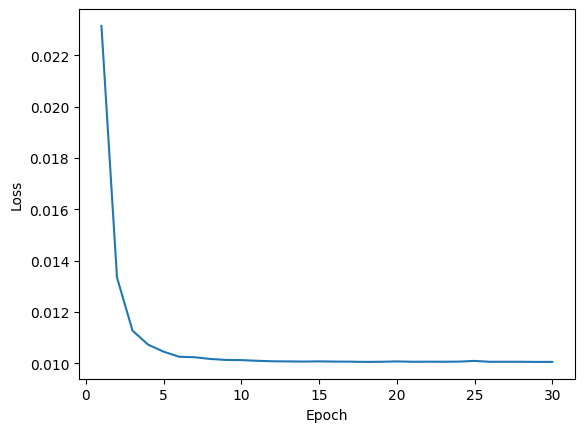

In [18]:
plt.plot(range(1,31), avg_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [17]:
popularity_pred_model.model_evaluation(test_x, test_y)

Evaluation Loss: 0.010437756501293432


/usr/local/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## User-based Embedding

In this part, I plan to use a LSTM model to extract personalized preference based on the commented article content sequences of each user.

In [18]:
class user_based_embedding(nn.Module):
    def __init__(self, hidden_dim = 64, output_dim = 64, content_embedding_dim = 100):
        super(user_based_embedding, self).__init__()
        self.content_embedding_dim = content_embedding_dim
        self.lstm = nn.LSTM(self.content_embedding_dim, hidden_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def user_commented_article(self, article_comment_dt, userid, cur_time):
        current_time = pd.to_datetime(cur_time)
        commented_article = article_comment_dt[article_comment_dt['createDate'] <= cur_time]
        user_commented = commented_article[commented_article['userID'] == userid]
        return user_commented
    
    '''def user_commented_article_sequence(self, article_comment_dt, userid, cur_time):
        user_commented = self.user_commented_article(article_comment_dt, userid, cur_time)
        commented_sequence = user_commented.sort_values('createDate')['articleID'].to_list()
        return commented_sequence'''
    
    def user_commented_article_sequence(self, group):
        commented_sequence = group.sort_values('createDate')['articleID'].to_list()
        return commented_sequence
    
    def text_to_w2v_embedding(self, text, model):
        words = re.split(r'[^\w]', text)
        words = [word for word in words if word in model.wv]
        if not words:
            return np.zeros(self.content_embedding_dim)
        return np.mean([model.wv[word] for word in words], axis = 0)
    
    def content_embedding(self, article_dt):
        word2vec_model = Word2Vec.load('word2vec_model.model')
        content_emb = article_dt[['articleID','text']]
        content_emb['embedding'] = content_emb['text'].apply(lambda x: self.text_to_w2v_embedding(x, word2vec_model))
        #content_emb['embedding_n'] = (content_emb['embedding'] - content_emb['embedding'].mean(axis = 0)) / content_emb['embedding'].std(axis = 0)
        article_emb_dict = dict(zip(content_emb['articleID'], content_emb['embedding']))
        return article_emb_dict
    
    def user_commented_article_embedding(self, user_comment_dt):
        word2vec_model = Word2Vec.load('word2vec_model.model')
        return np.vstack(user_comment_dt.apply(lambda row: self.text_to_w2v_embedding(row['text'], word2vec_model), axis = 1))
    
    def all_user_content_embedding(self, article_dt, article_comment_dt, cur_time):
        sorted_comment_dt = article_comment_dt[article_comment_dt['createDate'] <= cur_time].sort_values(['createDate'])
        article_emb_dict = self.content_embedding(article_dt)
        print('Start embedding')
        #user_content_embedding = pd.DataFrame({'userID': article_comment_dt['userID'].unique()})
        print('Extracting commented article sequence')
        user_content_embedding = sorted_comment_dt.groupby('userID').apply(self.user_commented_article_sequence).reset_index()
        user_content_embedding.columns = ['userID', 'commented_article_sequence']
        #user_content_embedding['commented_article_sequence'] = user_content_embedding['userID'].apply(lambda x: self.user_commented_article_sequence(article_comment_dt, x, cur_time))
        print('Embedding')
        user_content_embedding['embedding'] = user_content_embedding['commented_article_sequence'].apply(lambda x: np.stack([article_emb_dict[article] for article in x]))
        all_user_emb = dict(zip(user_content_embedding['userID'], user_content_embedding['embedding']))
        print('Embedding completed')
        #user_content_embedding = sorted_comment_dt.groupby('userID').apply(lambda x: self.user_commented_article_embedding(x)).reset_index().rename(columns = {0:'Embedding'})
        #print('Embedding completed')
        #print('Embedding time: ', time.time() - start_time)
        #all_user_emb = dict(zip(user_content_embedding['userID'], user_content_embedding['Embedding']))
        return all_user_emb

    def embedding_padding(self, all_user_emb):
        content_embeddings = [v for v in all_user_emb.values()]
        lengths = [v.shape[0] for v in all_user_emb.values()]
        sorted_len, sorted_idx = torch.sort(torch.tensor(lengths), descending = True)
        userids = list(all_user_emb.keys())
        userids = [userids[i] for i in sorted_idx.tolist()]
        content_sorted_tensors = [torch.from_numpy(content_embeddings[i][::-1].copy()) for i in sorted_idx]
        print('Start padding sequence')
        padded_input = nn.utils.rnn.pad_sequence(content_sorted_tensors, batch_first = True)
        #print('Start packing sequence')
        #packed_input = nn.utils.rnn.pack_padded_sequence(padded_input, sorted_len, batch_first = True)
        return userids, padded_input
    
    def forward(self, x):
        output_, (hidden, cell) = self.lstm(x)
        output = self.fc(hidden.squeeze(0))
        #_, reversed_idx = torch.sort(sorted_idx)
        #output = output[reversed_idx]
        return output
    

## Combine article popularity prediction and user-based embedding to make recommendation

In [116]:
class news_article_recommendation(nn.Module):
    def __init__(self, lstm_hidden_dim = 100, lstm_output_dim = 100):
        super(news_article_recommendation, self).__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.lstm_output_dim = lstm_output_dim
        self.lstm_model = user_based_embedding(self.lstm_hidden_dim, self.lstm_output_dim)
        #self.linear_model = nn.Linear(2,1)
        self.criterion = nn.BCELoss()
        #self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.lstm_model.parameters(), lr = 0.0001)
        self.epochs = 5
        
    def get_true_article(self, article_dt, article_comment_dt, userid):
        true_article_ids = article_comment_dt[article_comment_dt['userID'] == userid]['articleID'].unique()
        articles = article_dt.reset_index()
        true_article_position = articles.loc[articles['articleID'].isin(true_article_ids)].index
        return true_article_ids, true_article_position
    
    def label(self, idx, n):
        label = np.zeros(n)
        label[idx] = 1
        return label
    
    def get_true_label(self, article_dt, article_comment_dt, userid):
        article_num = article_dt['articleID'].nunique()
        labels = np.zeros(article_num)
        true_article_ids, true_article_position = self.get_true_article(article_dt, article_comment_dt, userid)
        labels[true_article_position] = 1
        return labels
    
    def true_label(self, users, article_dt, article_comment_dt):
        articles = article_dt.reset_index()
        n_articles = article_dt['articleID'].nunique()
        user_article_lists = article_comment_dt.groupby('userID')['articleID'].agg(list).reset_index()
        user_article_lists['article_pos'] = user_article_lists['articleID'].apply(lambda x: articles.loc[articles['articleID'].isin(x)].index)
        user_article_lists['label'] = user_article_lists['article_pos'].apply(lambda x: self.label(x, n_articles))
        sorting_key = {k:v for k,v in enumerate(users)}
        user_article_lists['sorting_key'] = user_article_lists['userID'].map(sorting_key)
        user_article_sorted = user_article_lists.sort_values(by = 'sorting_key')
        
        true_label = np.vstack(user_article_sorted['label'])
        return user_article_sorted, true_label
    
    def user_embed(self, article_dt, article_comment_dt, cur_time):
        all_user_embed = self.lstm_model.all_user_content_embedding(article_dt, article_comment_dt, cur_time)
        user_ids, all_user_embed_padded = self.lstm_model.embedding_padding(all_user_embed)
        return user_ids, all_user_embed_padded
        
    def user_embed_lstm(self, all_user_embed_padded):
        user_embed_lstm = self.lstm_model.forward(all_user_embed_padded)
        user_embed_normalized = F.normalize(user_embed_lstm, p = 2, dim = 0).float()
        return user_embed_normalized
    
    def user_article_sim(self, user_embed, article_embed):
        article_embed_normalized = F.normalize(torch.tensor(article_embed), p = 2, dim = 0).float()
        #print('Calculating article and user similarity')
        article_user_sim_mat = torch.matmul(user_embed, article_embed_normalized.t())
        #article_user_sim_mat = torch.matmul(user_embed, article_embed_normalized.t())
        return article_user_sim_mat
    
    def recommend(self, existing_user, user, user_embed, article_embed, article_user_sim_mat, article_dt, article_comment_dt, article_popularity, k):
        articles = article_dt.reset_index()
        #existing_user = article_comment_dt['userID'].unique()
        if user in existing_user:
            #user_pos = np.where(existing_user == user)[0]
            #print(user_pos)
            recommend_rating = 0.5 * article_user_sim_mat + 0.5 * article_popularity.t()
            topk_val, topk_idx = torch.topk(recommend_rating, k = k, dim = 1)
            #print(topk_idx)
            #user_topk_idx = topk_idx[user_pos]
            #print(user_topk_idx)
            user_topk_idx = topk_idx.tolist()[0]
            #user_topk_article = articles.loc[user_topk_idx, 'articleID']
            user_topk_article = articles.loc[user_topk_idx, 'articleID']
            #print(user_topk_article)
            return user_topk_article.tolist()
        else:
            topk_val, topk_idx = torch.topk(article_popularity.t(), k = k, dim = 1)
            topk_idx = topk_idx.tolist()[0]
            return articles.loc[topk_idx, 'articleID'].tolist()
    
    '''def recommend_label(self, users, article_user_sim_mat, article_dt, article_popularity, k):
        user = pd.DataFrame({'userID': users})
        n_articles = article_dt['articleID'].nunique()
        articles = article_dt.reset_index()
        #print('Initializing')
        user['label'] = [np.zeros(n_articles) for i in range(len(users))]
        #print('Recommending')
        recommend_rating = 0.5 * article_user_sim_mat + 0.5 * article_popularity_pred.t()
        topk_val, topk_idx = torch.topk(recommend_rating, k = k, dim = 1)
        user['recommend_article'] = topk_idx.tolist()
        user['label'] = user['recommend_article'].apply(lambda x: self.label(x, n_articles))
        
        recommend_label = np.vstack(user['label'])
        return recommend_label'''
    
    def recommend_label(self, i, j, article_user_sim_mat, article_dt, article_popularity, k):
        #user = pd.DataFrame({'userID': users})
        #n_articles = article_dt['articleID'].nunique()
        #articles = article_dt.reset_index()
        #recommend_rating = 0.5 * article_user_sim_mat + 0.5 * article_popularity_pred.t()
        #recommend_rating = 0.5 * article_user_sim_mat[i:j] + 0.5 * article_popularity_pred.t()[i:j]
        gumbel_softmax = F.gumbel_softmax(article_user_sim_mat, hard = False)
        topk_indices = torch.topk(gumbel_softmax, k = k, dim = 1).indices
        one_hot_topk = F.one_hot(topk_indices, num_classes = article_user_sim_mat.size(1))
        differentiable_topk = one_hot_topk.sum(dim = 1)
        recommend_rating = differentiable_topk
        #recommend_rating = article_user_sim_mat
        #user['label'] = recommend_rating.tolist()
        #recommend_label = np.vstack(user['label'])
        #return recommend_label
        return recommend_rating
    
    def recommend_label2(self, users, i, j, article_user_sim_mat, article_dt, article_popularity, k):
        if user in users:
            gumbel_softmax = F.gumbel_softmax(0.5 * article_user_sim_mat + 0.5 * article_popularity_pred.t()[i:j], hard = False)
            topk_indices = torch.topk(gumbel_softmax, k = k, dim = 1).indices
            one_hot_topk = F.one_hot(topk_indices, num_classes = article_user_sim_mat.size(1))
            differentiable_topk = one_hot_topk.sum(dim = 1)
            recommend_res = differentiable_topk
            return recommend_res
        else:
            topk_indices = torch.topk(article_popularity_pred.t(), k = k, dim = 1).indices
            one_hot_topk = F.one_hot(topk_indices, num_classes = 2)
            return one_hot_topk
    
    def model_training(self, userids, train_x, train_y, article_embed, article_dt, article_popularity, k):
        #train_dataset = TensorDataset(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
        #train_loader = DataLoader(train_dataset, batch_size = self.batchsize, shuffle = True)
        for param in self.lstm_model.parameters():
            param.requires_grad_(True)
        
        batch_size = 128
        avg_loss_lst = []
        
        for epoch in range(self.epochs):
            #print(f'Epoch {epoch + 1}')
            self.lstm_model.train()
            total_loss = 0
            correct_predictions = 0
            
            batch = 0
            for i in range(0, train_x.shape[0], batch_size):
                batch += 1
                self.optimizer.zero_grad()
                x = train_x[i:i + batch_size]
                userid = userids[i:i + batch_size]
                y = train_y[i:i + batch_size]
                
                user_embed = self.user_embed_lstm(x)
                article_user_sim_mat = self.user_article_sim(user_embed, article_embed)
                pred = self.recommend_label(i, i + batch_size, article_user_sim_mat, article_dt, article_popularity, k)
                loss = self.criterion(torch.sigmoid(pred), y)
                #print(torch.sigmoid(pred))
                #loss = self.criterion(pred, y)
                #print(f'Batch {batch} Loss: {loss}')
                loss.backward(retain_graph = True)
                
                #for param in self.lstm_model.parameters():
                #    print(param.grad)
                    
                self.optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / (train_x.shape[0] // batch_size)
            #accuracy = correct_predictions / len(your_data)
            #print(f'Epoch: {epoch+1}, Average loss: {avg_loss}')

        
        #predictions = (torch.sigmoid(outputs) > 0.5).float()
        #correct_predictions += (predictions == labels).sum().item()
        

    def model_pred(self, existing_users, userids, val_x, val_y, article_embed, article_dt, article_comment_dt, article_popularity, k):
        
        self.lstm_model.eval()
        pred_df = pd.DataFrame({'userID': userids})
        preds = []
            
        for i in range(0, val_x.shape[0]):
            #print(i)
            x = val_x[i]
            userid = userids[i]
            user_embed = self.user_embed_lstm(x)
            article_user_sim_mat = self.user_article_sim(user_embed, article_embed)
            #print(article_user_sim_mat.shape)
            #print(article_popularity.shape)
            pred = self.recommend(existing_users, userid, user_embed, article_embed, article_user_sim_mat, article_dt, article_comment_dt, article_popularity, k)
            preds.append(pred)
        
        pred_df['articles'] = preds
        return pred_df
         
        

In [117]:
recommendation_model = news_article_recommendation()

In [21]:
comment_train1 = comment_dt[(comment_dt['createDate'] >= '2020-03-16 00:00:00') & (comment_dt['createDate'] < '2020-04-01 00:00:00')]
comment_train1 = comment_train1[comment_train1['userID'].isin(valid_user)]
article_comment_train1 = article_dt.merge(comment_train1, on = 'articleID', how = 'inner')
article_train1 = article_dt[article_dt['articleID'].isin(article_comment_train1['articleID'].unique())]
train_x1 = popularity_pred_model.content_recency_embedding(article_train1, cur_time_train)
train_y1 = popularity_pred_model.article_popularity(article_comment_train1, cur_time_train)

In [22]:
avg_n_comment = comment_train1.groupby('userID').size().reset_index().rename(columns = {0: 'Count'})['Count'].mean()
avg_n_comment

6.336257556586531

In [23]:
avg_n_comment2 = comment_test.groupby('userID').size().reset_index().rename(columns = {0:'Count'})['Count'].mean()
avg_n_comment2

3.1614384360147074

In [24]:
article_popularity_pred = popularity_pred_model.forward(torch.FloatTensor(train_x1))

In [25]:
article_embedding = popularity_pred_model.content_embedding(article_train1)

In [26]:
userids, user_embed_normalized = recommendation_model.user_embed(article_train1, article_comment_train1, cur_time_train)

/var/folders/xq/h26tvj1x3fbfj2kh6r17zc_w0000gn/T/ipykernel_52654/2589200107.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emb['embedding'] = content_emb['text'].apply(lambda x: self.text_to_w2v_embedding(x, word2vec_model))


Start embedding
Extracting commented article sequence
Embedding
Embedding completed
Start padding sequence


In [27]:
_, true_label = recommendation_model.true_label(userids, article_train1, article_comment_train1)

In [28]:
x_train = user_embed_normalized

In [ ]:
x_train.requires_grad_(True)
y_train = torch.FloatTensor(true_label)
y_train.requires_grad_(True)
recommendation_model.model_training(userids, x_train, y_train, article_embedding, article_train1, article_popularity_pred, 5)

In [71]:
test_x = popularity_pred_model.content_recency_embedding(article_test, cur_time_test)
test_y = popularity_pred_model.article_popularity(article_comment_test, cur_time_test)

In [72]:
article_popularity_pred_test = popularity_pred_model.forward(torch.FloatTensor(test_x))

In [38]:
article_embedding_test = popularity_pred_model.content_embedding(article_test)

In [39]:
userids_test, user_embed_normalized_test = recommendation_model.user_embed(article_test, article_comment_test, cur_time_test)

/var/folders/xq/h26tvj1x3fbfj2kh6r17zc_w0000gn/T/ipykernel_52654/2589200107.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emb['embedding'] = content_emb['text'].apply(lambda x: self.text_to_w2v_embedding(x, word2vec_model))


Start embedding
Extracting commented article sequence
Embedding
Embedding completed
Start padding sequence


In [40]:
_, true_label_test = recommendation_model.true_label(userids_test, article_test, article_comment_test)

In [41]:
x_test = user_embed_normalized_test

In [104]:
y_test = torch.FloatTensor(true_label_test)
pred_res = recommendation_model.model_pred(userids, userids_test, x_test, y_test, article_embedding_test, article_test, article_comment_test, article_popularity_pred_test, 20)

In [105]:
true_df = article_comment_test.groupby('userID')['articleID'].agg(list).reset_index().rename(columns = {'articleID':'true_articles'})
eval_df = pred_res.merge(true_df, how = 'inner', on = 'userID')
eval_df['intersect'] = eval_df.apply(lambda row: len(set(row['articles']).intersection(set(row['true_articles']))), axis = 1)
eval_df['true_num'] = eval_df['true_articles'].apply(lambda x: len(x))